heart disease predict with xgboost

1. problem statement

Heart disease is one of the major causes of death globally. Early prediction allows timely medical intervention. This project aims to build a machine learning model to predict the likelihood of heart disease based on patient clinical features.


1.1 objective

Predict whether a patient has heart disease (target = 0 or 1), derived from the original `num` variable.


1.2 data sources

The dataset is from the UCI Machine Learning Repository (Heart Disease Dataset).  
It contains patient medical measurements such as age, blood pressure, cholesterol, heart rate, etc.

2. EDA

2.1 look up data set



In [ ]:
#load libraries
import numpy as np         # linear algebra
import pandas as pd        # data processing, CSV file I/O (e.g. pd.read_csv)
data = pd.read_csv('data/heart_disease_uci.csv', index_col=False,)
#look up data types and missing values
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [3]:
data.head(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


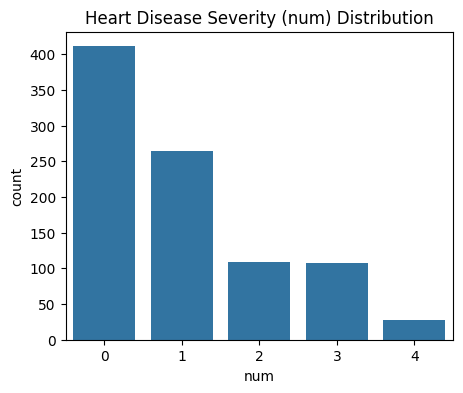

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x='num', data=data)#直接指出需要哪一列数据作为X计数即可，一般就是需要预测的Y
plt.title("Heart Disease Severity (num) Distribution")
plt.show()


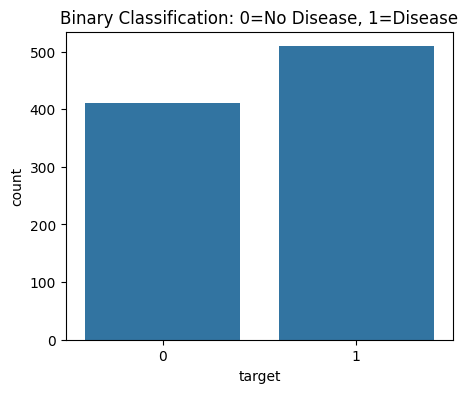

In [5]:
data['target'] = (data['num'] > 0).astype(int)
#把原来的num列转换成二分类的target列，0表示无病，1表示有病
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=data)#直接指出需要哪一列数据作为X计数即可
plt.title("Binary Classification: 0=No Disease, 1=Disease")
plt.show()

2.2 histogram

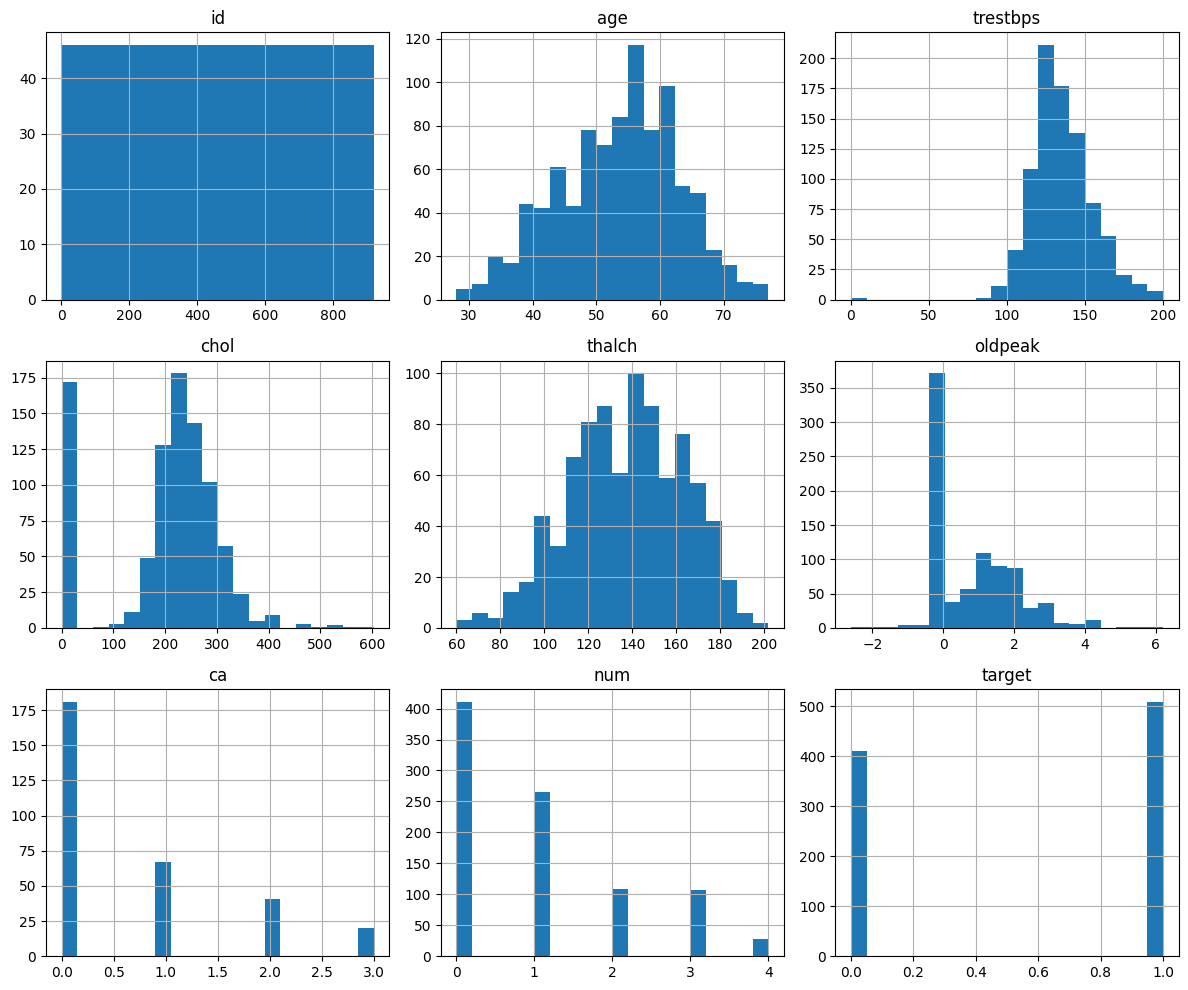

In [6]:
numeric_cols = data.select_dtypes(include=['int64','float64']).columns
#一步整合数值型变量
data[numeric_cols].hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

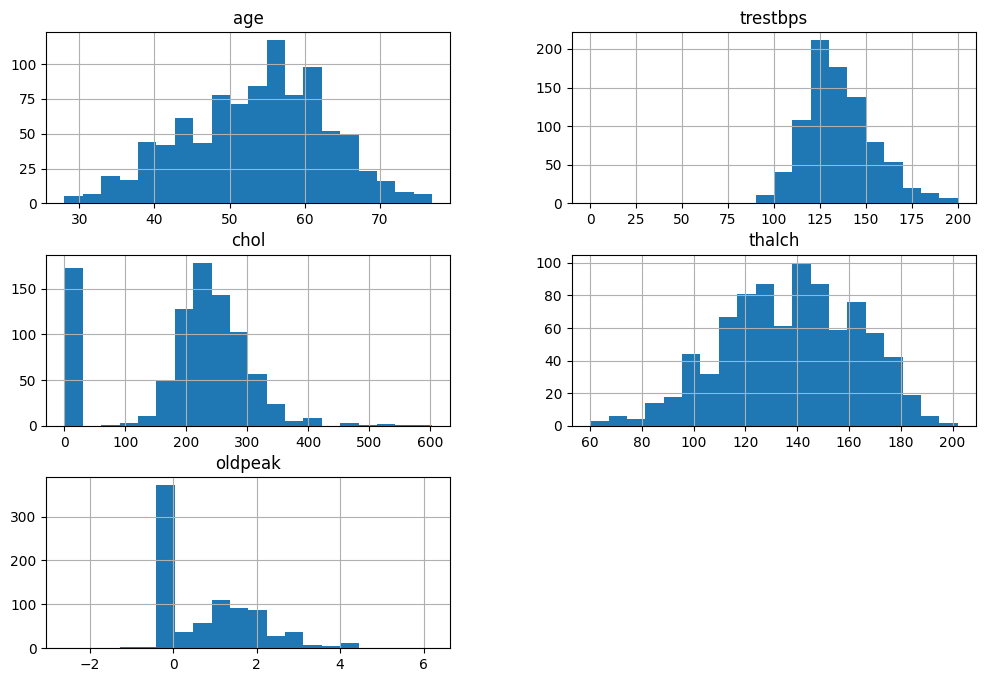

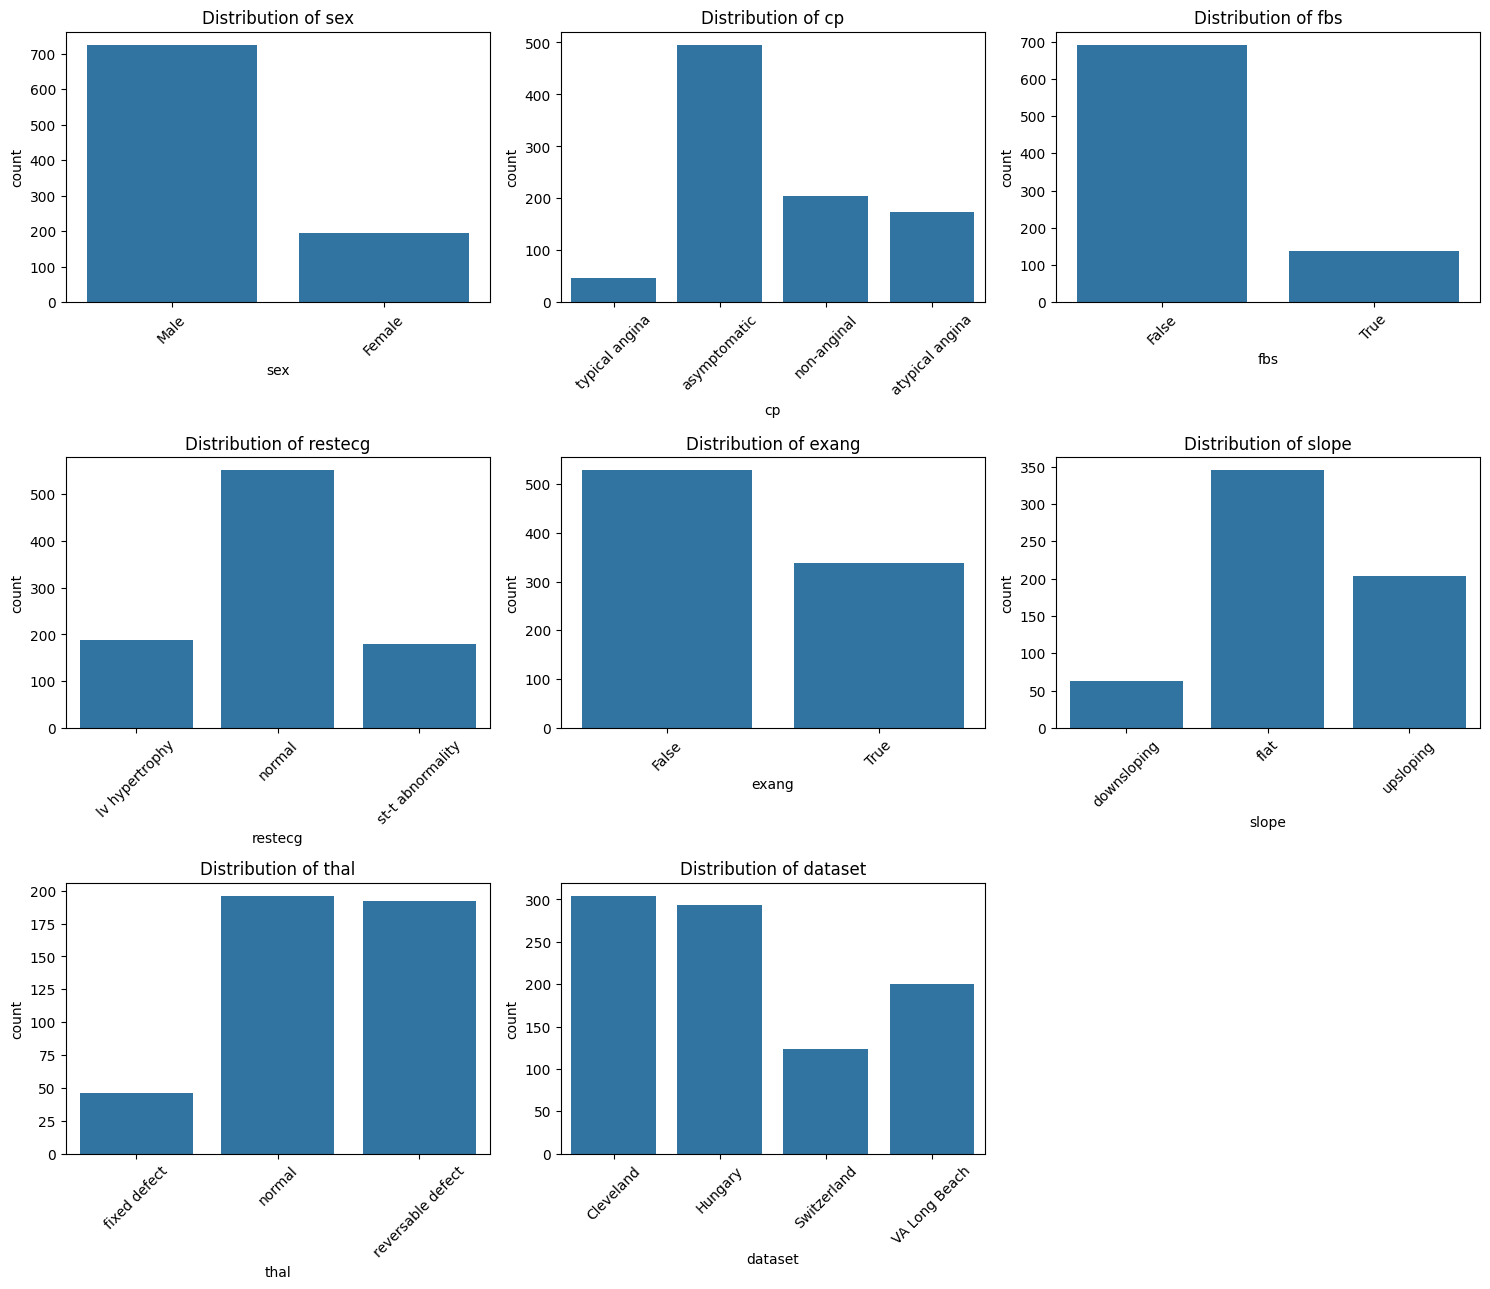

In [9]:
# Visualize continuous variables
continuous_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
data[continuous_cols].hist(figsize=(12,8), bins=20)
plt.show()
#.hist() 本身就内置了“自动子图功能”，sns.countplot()——每次只画一张图
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']
# Visualize categorical variables
import math

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset']

# 计算子图行列数（每行 3 个）
n_cols = 3
n_rows = 4

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=col, data=data)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


2.3 density

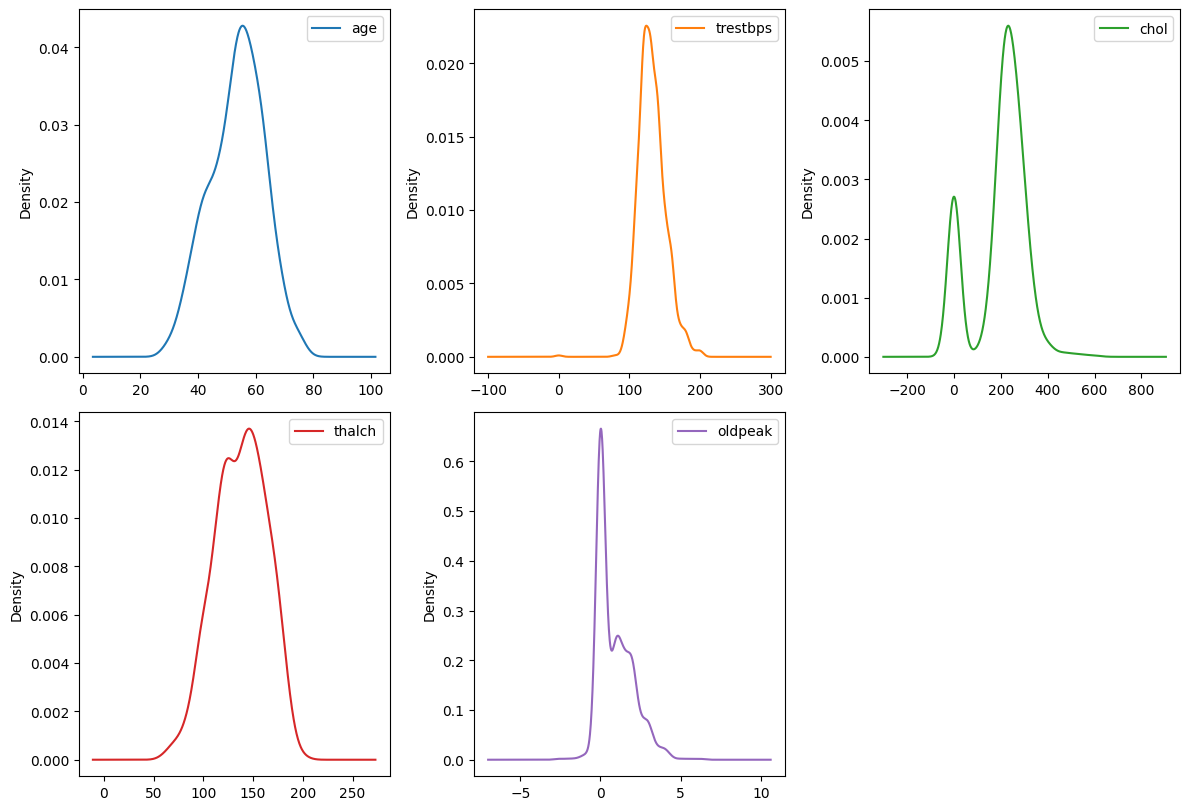

In [11]:
data[continuous_cols].plot(kind='density', subplots=True, layout=(3,3), figsize=(12,12), sharex=False)
plt.tight_layout()
plt.show()

2.4 skew

In [ ]:
skewness = data[continuous_cols].skew()
kurtosis = data[continuous_cols].kurtosis()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 age        -0.195994
trestbps    0.213334
chol       -0.613836
thalch     -0.211119
oldpeak     1.041427
dtype: float64

Kurtosis:
 age        -0.382930
trestbps    2.958664
chol        0.062273
thalch     -0.479725
oldpeak     1.127069
dtype: float64


2.5 correlation matrix

<Axes: title={'center': 'Breast Cancer Feature Correlation'}>

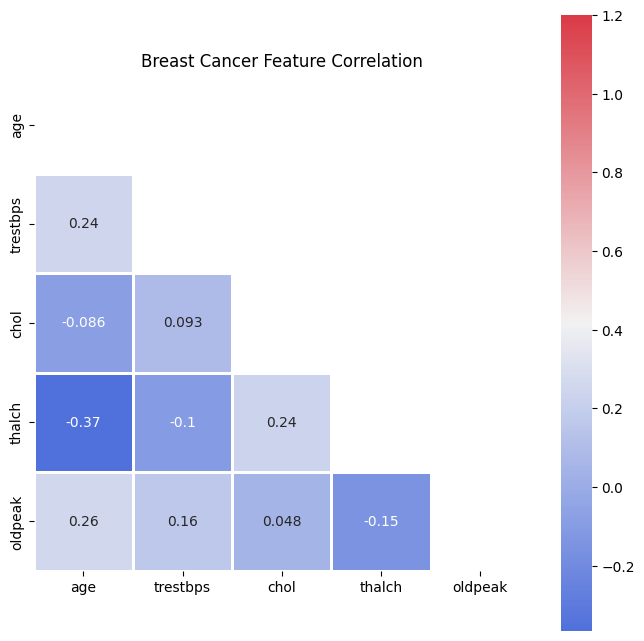

In [ ]:
corr_matrix = data[continuous_cols].corr()
#仅仅为了看变量之间有没有高度相关和替代性，并不是要选择和target相关度高的变量
# 生成 mask（上三角不显示）
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Breast Cancer Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[continuous_cols].corr(), vmax=1.2, square='square', cmap=cmap, mask=mask, 
            ax=ax,annot=True, fmt='.2g',linewidths=2)

2.6 comparison in target

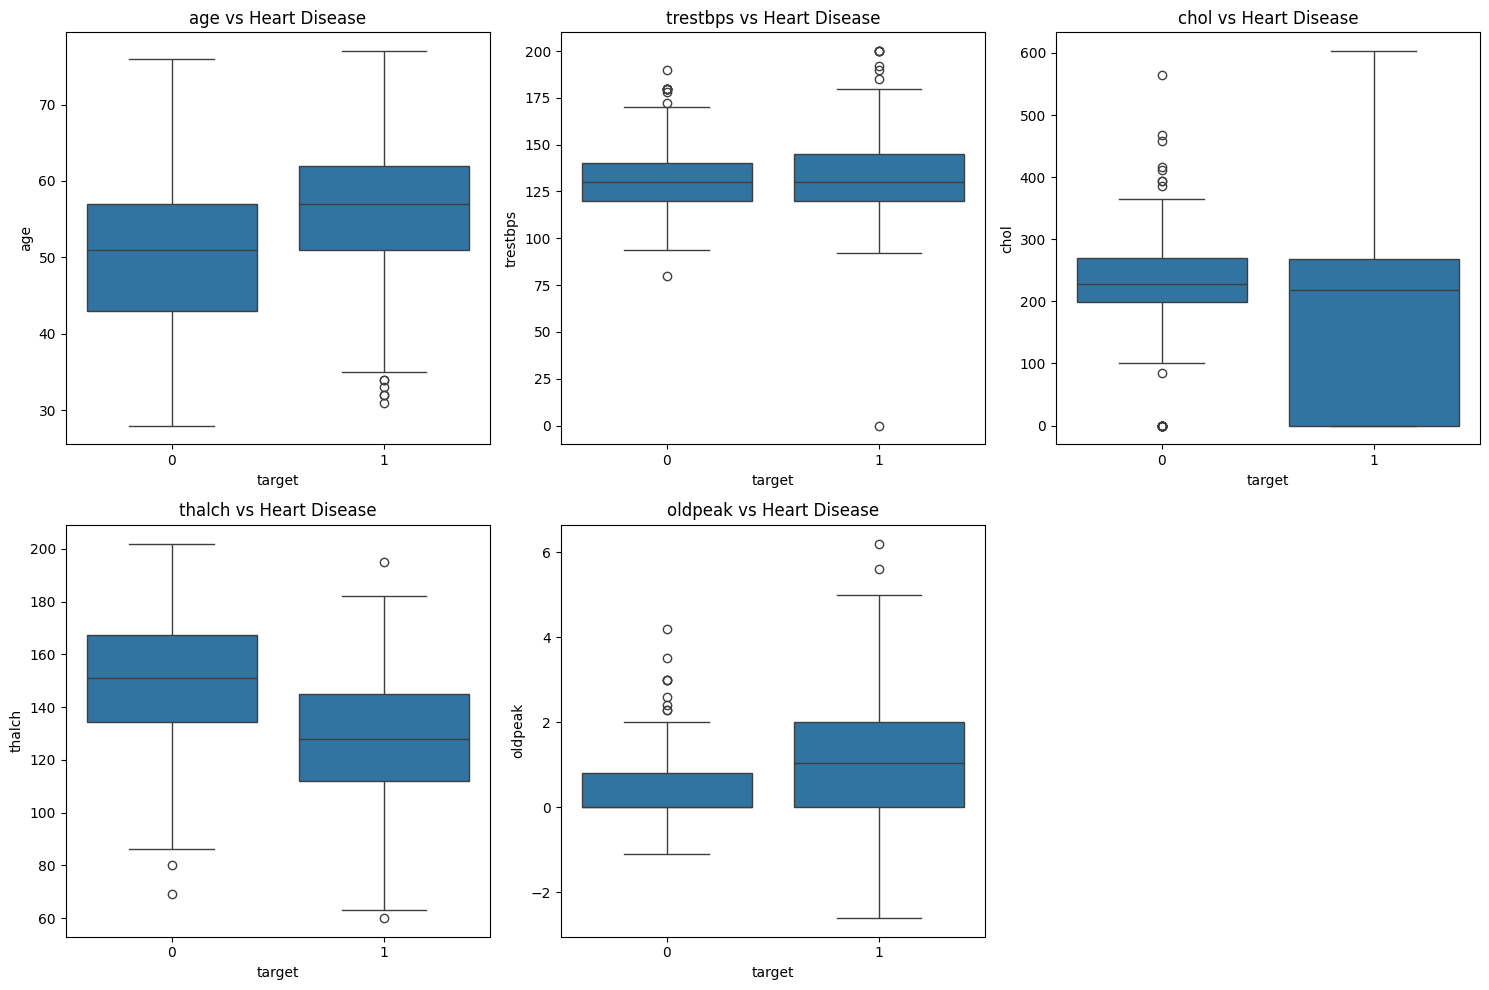

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()   # 让 axes 变成一维数组，方便循环

for i, col in enumerate(continuous_cols):
    sns.boxplot(x='target', y=col, data=data, ax=axes[i])
    axes[i].set_title(f"{col} vs Heart Disease")

# 如果子图数量少于格子数，可以关闭多余坐标轴
for j in range(len(continuous_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

observation

The dataset contains several features with missing values, most notably `ca` (611), `thal` (486),  
and `slope` (309), which require imputation before modeling. The target distribution is relatively 
balanced, with slightly more positive cases, making it suitable for standard classification models.

From the histograms and density plots, key continuous features show distinct patterns:  
`age`, `trestbps`, and `thalch` follow near-normal distributions, while `chol` and especially 
`oldpeak` display strong right skew, consistent with medical risk indicators. Skewness and kurtosis 
confirm that `oldpeak` has heavier tails and potential outliers.

Categorical variables show clinically meaningful distributions—most patients are male, have 
asymptomatic chest pain, normal resting ECG, and are primarily from Cleveland or Hungary datasets.

Boxplots reveal clear separation between disease and non-disease groups:  
patients with heart disease generally show **lower maximum heart rate (`thalch`)** and  
**higher ST depression (`oldpeak`)**, both known diagnostic markers. Other variables overlap more 
substantially, suggesting weaker predictive power individually.
